# Machine Learning: Gold Price Prediction

Table of Contents:
- Importing Libraries
- Importing Data
- Data Loading

Feature Expansion
Time-Series Split
Forecasting Horizon
Lagged Features
Machine Learning
Model Creation and Hyperparameter Tuning
Evaluating the Past
Predicting the Future
Feature Importance
Addendum
Conclusions

## Importing libraries

In [40]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_style('ticks')
sns.color_palette("tab10")
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score

## Importing Data

In [41]:
#Importing IAU ETF price data
gold = yf.Ticker("IAU").history(period="max")

In [42]:
gold.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2005-01-28 00:00:00-05:00,8.546,8.546,8.492,8.538,2888500,0.0,0.0,0.0
2005-01-31 00:00:00-05:00,8.446,8.462,8.398,8.454,759500,0.0,0.0,0.0
2005-02-01 00:00:00-05:00,8.422,8.428,8.394,8.424,347500,0.0,0.0,0.0
2005-02-02 00:00:00-05:00,8.446,8.446,8.408,8.446,1496500,0.0,0.0,0.0
2005-02-03 00:00:00-05:00,8.316,8.348,8.302,8.344,534000,0.0,0.0,0.0
2005-02-04 00:00:00-05:00,8.320,8.332,8.284,8.300,433500,0.0,0.0,0.0
2005-02-07 00:00:00-05:00,8.314,8.314,8.250,8.270,938000,0.0,0.0,0.0
2005-02-08 00:00:00-05:00,8.256,8.282,8.218,8.258,880500,0.0,0.0,0.0
2005-02-09 00:00:00-05:00,8.218,8.272,8.208,8.268,404500,0.0,0.0,0.0


Since this data comes from the `yfinance` library, it does not require any additional cleaning or formatting.

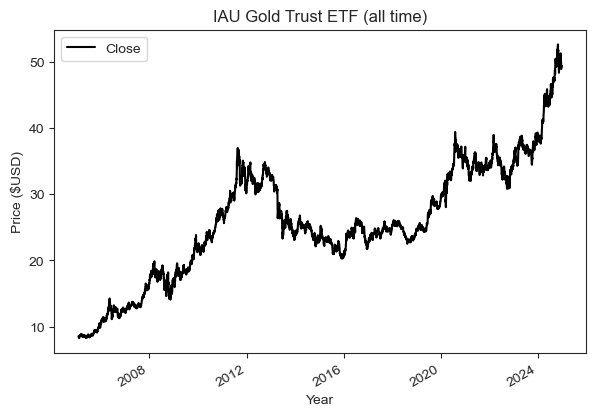

In [43]:
#Plotting close price history
gold.plot.line(y="Close", use_index=True, color='k')
plt.title("IAU Gold Trust ETF (all time)")
plt.tight_layout(pad=3)
plt.xlabel("Year")
plt.ylabel("Price ($USD)")
plt.savefig("images/GoldETF_All_Time.png", bbox_inches='tight')
plt.show()

In [44]:
#Removing unnecessary Dividends and Stock Splits columns
del gold["Dividends"]
del gold["Stock Splits"]

In [45]:
#Adding tomorrow's price column
gold["Next week"] = gold["Close"].shift(-7)

The chart of our interest here is going to be the weekly chart. Our goal is to predict whether the price rises or falls next week, not necessarily it's exact value in the next week.

In [46]:
#Adding target column; 1 for price rise, 0 else
gold["Weekly Target"] = (gold["Next week"] > gold["Close"]).astype(int)

In [47]:
gold

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target
Date,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546000,8.492000,8.538000,2888500,0.0,8.258,0
2005-01-31 00:00:00-05:00,8.446000,8.462000,8.398000,8.454000,759500,0.0,8.268,0
2005-02-01 00:00:00-05:00,8.422000,8.428000,8.394000,8.424000,347500,0.0,8.362,0
2005-02-02 00:00:00-05:00,8.446000,8.446000,8.408000,8.446000,1496500,0.0,8.424,0
2005-02-03 00:00:00-05:00,8.316000,8.348000,8.302000,8.344000,534000,0.0,8.524,1
...,...,...,...,...,...,...,...,...
2024-12-18 00:00:00-05:00,49.799999,49.840000,48.840000,48.930000,7227700,0.0,NaN,0
2024-12-19 00:00:00-05:00,49.009998,49.090000,48.830002,49.000000,3855400,0.0,NaN,0
2024-12-20 00:00:00-05:00,49.380001,49.680000,49.320000,49.500000,5019400,0.0,NaN,0


It is well known that major market shifts (e.g. Black Swan events, financial crises, etc.) affect how our learning algorithm trains itself. In this project, we will pureposefully leave the 2008 financial crisis data inside the training set. This is because gold is a relatively volatile instrument anyways, and its markets usually respond to unforseen geopolitical (or other) events.

## Basic Machine Learning Model

In [96]:
#Building an initial Machine Learning Model
model = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=57)
train = gold.iloc[:-100] #Or time-series split
test = gold.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=1000,
                       random_state=57)

In [97]:
preds = model.predict(test[predictors])

In [98]:
preds = pd.Series(preds, index=test.index)

In [99]:
precision_score(test["Target"], preds)

0.6060606060606061

<Axes: xlabel='Date'>

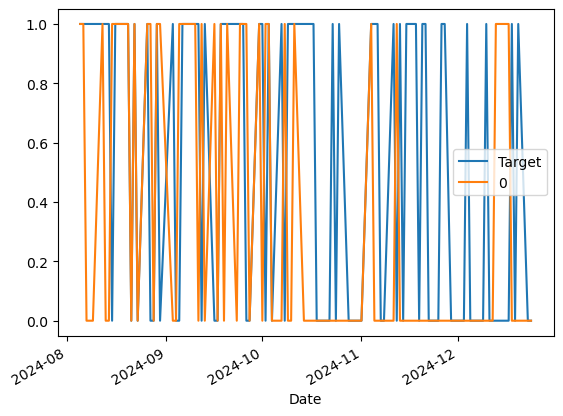

In [100]:
results = pd.concat([test["Target"], preds], axis=1)
results.plot()

In [101]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    results = pd.concat([test["Target"], preds], axis=1)
    return results

In [102]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [103]:
predictions = backtest(gold, model, predictors)

In [104]:
predictions

,Target,Predictions
Date,,
2020-10-13 00:00:00-04:00,0,0
2020-10-14 00:00:00-04:00,0,0
2020-10-15 00:00:00-04:00,0,0
2020-10-16 00:00:00-04:00,1,0
2020-10-19 00:00:00-04:00,1,0
...,...,...
2024-12-18 00:00:00-05:00,1,1
2024-12-19 00:00:00-05:00,0,0
2024-12-20 00:00:00-05:00,1,0


In [105]:
predictions["Predictions"].value_counts()

Predictions
0    842
1    215
Name: count, dtype: int64

In [106]:
#Our Model's precision
precision_score(predictions["Target"], predictions["Predictions"])

0.5581395348837209

In [107]:
#Percentage of days the price went up or down
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.513718
0    0.486282
Name: count, dtype: float64

It turns out that following our simple model outperforms buying or selling according to the documented percentage of days that the price went up or down. This is good.

## Feature Expansion

In [108]:
#Defining different forecasting horizons
horizons = [2, 50, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    moving_average = gold.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    gold[ratio_column] = gold["Close"] / moving_average["Close"]

    trend_column = f"Trend_{horizon}"
    gold[trend_column] = gold.shift(-1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [109]:
gold.dropna(inplace=True)
gold.head(10)

,Open,High,Low,Close,Volume,Capital Gains,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_50,Trend_50,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
2014-10-27 00:00:00-04:00,16.995354,17.038970,16.762740,16.835432,45150,0.0,17.242502,1,0.992288,1.0,0.862043,20.0,0.848238,27.0,0.771111,117.0,0.460191,452.0
2014-10-28 00:00:00-04:00,16.908120,17.271580,16.777275,17.242502,61900,0.0,16.980814,0,1.011945,0.0,0.887313,20.0,0.871728,26.0,0.790305,117.0,0.472022,452.0
2014-10-29 00:00:00-04:00,17.373349,17.373349,16.864507,16.980814,83650,0.0,16.762735,0,0.992354,0.0,0.878380,20.0,0.861484,26.0,0.778909,116.0,0.465660,451.0
2014-10-30 00:00:00-04:00,16.893581,16.980812,16.719121,16.762735,50900,0.0,16.719124,0,0.993537,0.0,0.871688,19.0,0.853663,25.0,0.769474,116.0,0.460443,450.0
2014-10-31 00:00:00-04:00,16.849969,16.864508,16.646432,16.719124,75600,0.0,16.588276,0,0.998697,0.0,0.873807,18.0,0.854521,24.0,0.768048,115.0,0.460024,450.0
2014-11-03 00:00:00-05:00,16.733660,16.806352,16.428354,16.588276,96350,0.0,16.253895,0,0.996072,1.0,0.871631,18.0,0.851207,24.0,0.762608,116.0,0.457210,451.0
2014-11-04 00:00:00-05:00,16.428355,16.515584,16.224817,16.253895,66900,0.0,16.704582,1,0.989819,2.0,0.859048,19.0,0.837673,24.0,0.747845,116.0,0.448729,452.0
2014-11-05 00:00:00-05:00,16.210278,16.762736,16.108509,16.704582,113200,0.0,16.791817,1,1.013674,2.0,0.887670,19.0,0.864375,24.0,0.769098,117.0,0.461908,452.0
2014-11-06 00:00:00-05:00,16.704586,16.849970,16.617356,16.791817,116400,0.0,19.030724,1,1.002604,2.0,0.897004,19.0,0.872620,25.0,0.773645,118.0,0.464992,452.0


In [118]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=50, random_state=57)

In [111]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    results = pd.concat([test["Target"], preds], axis=1)
    return results

In [112]:
predictions = backtest(gold, model, new_predictors)

In [113]:
predictions["Predictions"].value_counts()

Predictions
0.0    44
1.0    13
Name: count, dtype: int64

In [114]:
precision_score(predictions["Target"], predictions["Predictions"])

1.0

In [115]:
predictions

,Target,Predictions
Date,,
2024-10-03 00:00:00-04:00,1,0.0
2024-10-04 00:00:00-04:00,0,0.0
2024-10-07 00:00:00-04:00,1,0.0
2024-10-08 00:00:00-04:00,0,0.0
2024-10-09 00:00:00-04:00,1,1.0
2024-10-10 00:00:00-04:00,1,1.0
2024-10-11 00:00:00-04:00,1,1.0
2024-10-14 00:00:00-04:00,1,1.0
2024-10-15 00:00:00-04:00,1,1.0


In [116]:
#other input features: other indices across the world that trade in earlier hours than gold
#                       news, key stocks in the index, resolution increase (hours, minutes, ticks)

In [119]:
#Trebalo bi time series split i još dodat indikatore kao MACD, RSI, EMA i druge indikatore.

In [121]:
#Inputs: Close, Price Change, RSI, MACD, Volume, SMA, EMA, CL, GLD
# feed in 10 days of previous data